In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
# sk-learn imports are below

In [2]:
from utilities import *

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 100)
plt.ioff()

sns.set_context('talk')
sns.set_style('darkgrid')

## Computational Setup

### Multi-Processing

In [4]:
# Set to false if you don't want to use all of your computer at once
go_for_broke = True

In [5]:
if go_for_broke:
    n_jobs = os.cpu_count()
else:
    n_jobs = 1
    
print(f'Configured to use {n_jobs} out of {os.cpu_count()} cpu cores visible to the OS')

Configured to use 4 out of 4 cpu cores visible to the OS


### Model Fitting
Models can be loaded from disk; some take a while to fit

In [6]:
# On false, all models wiil be refit (takes a while!)
load_from_disk = True

# Load the Data
The first task will be classify the columns as:
- irrelevant
- categorical predictor (including boolean)
- ordinal predictor
- main target
- subsidiary target (questions that obviously reveal the answer to the main target)

I highly recommend you look at the codebook with a spreadsheet viewer and not the dataframe itself

In [7]:
df       = pd.read_csv('dataset.csv' , index_col = 0)
codebook = pd.read_csv('codebook.csv', index_col = 0)

# Classify the Columns

## The Target Variable

Target variables:

- Questions 36–40 are explicitly career-plan related and contain our target
- Questions 41–54 have the potential to be quite career related and need to be screened for data leakage

In [8]:
def getQs(q):
    all_qs = codebook.index
    qs     = lfilter(lambda row : re.match(q, row), all_qs)
    return codebook.loc[qs]

In [9]:
getQs('Q38')

,Question Text,var_type,checkbox_text,notes,num_categories,num_missing
Q38.a,Research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,82
Q38.b,Research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,135
Q38.c,Research within government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,196
Q38.d,Non-research in academia,Ordinal,NaN,Likelihood of pursuing career path,6,223
Q38.e,Medical research,Ordinal,NaN,Likelihood of pursuing career path,6,185
Q38.f,Non-research in industry,Ordinal,NaN,Likelihood of pursuing career path,6,262
Q38.g,Non-research in government or non-profit,Ordinal,NaN,Likelihood of pursuing career path,6,290


In [10]:
def getQNum(q):
    num = re.match('Q(\d*)', q)
    if not num:
        return None
    num = int(num.group(1))
    return num

In [11]:
def filterQRange(low, hi, exclude = True):
    def filterQ(q):
        n = getQNum(q)
        if not n:
            return exclude
        else:
            if low <= n <= hi:
                return not exclude
            else:
                return exclude
    
    return filterQ

The target will be anyone likely or very likely (4 or 5) to pursue research in academia

In [12]:
target_all = (df['Q38.a'] >= 4).rename('Academic Research Likely')
print(f'{sum(target_all)/len(target_all) : .1%} are Likely to Pursue Academic Research')

 71.0% are Likely to Pursue Academic Research


In [13]:
def bar_plot(col, name=''):
    return plot(sns.countplot, y = df[col].rename(name), hue = target_all)

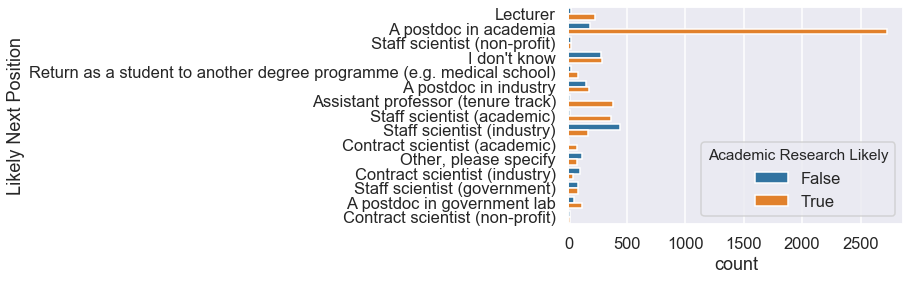

In [14]:
bar_plot('Q40', 'Likely Next Position')

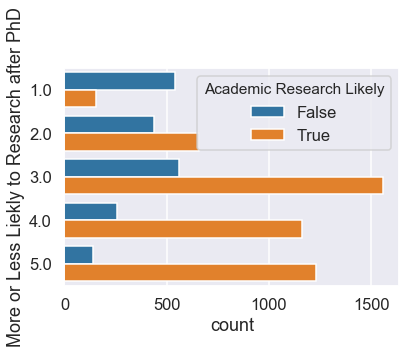

In [15]:
bar_plot('Q43.a', 'More or Less Liekly to Research after PhD')

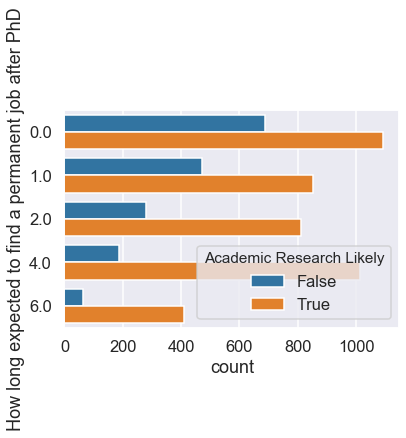

In [16]:
bar_plot('Q42', 'How long expected to find a permanent job after PhD')

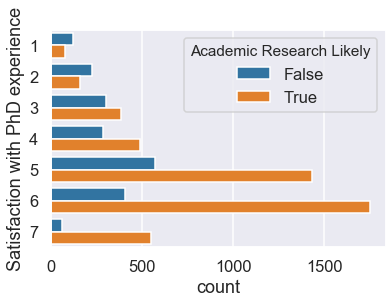

In [17]:
bar_plot('Q19.a', 'Satisfaction with PhD experience')

In [18]:
def checkbox_plot(q, label_col = 'checkbox_text'):
    qs           = getQs(q)
    title        = qs['Question Text'].iloc[0]
    labels       = qs[label_col].rename(title)
    data         = df[qs.index]
    data.columns = labels
    data         = pd.concat([data, target_all], axis = 'columns')
    data = data.melt(id_vars='Academic Research Likely', var_name=title)
    data = data[data.value]
    return plot(sns.countplot, y = title, data = data, hue = 'Academic Research Likely')

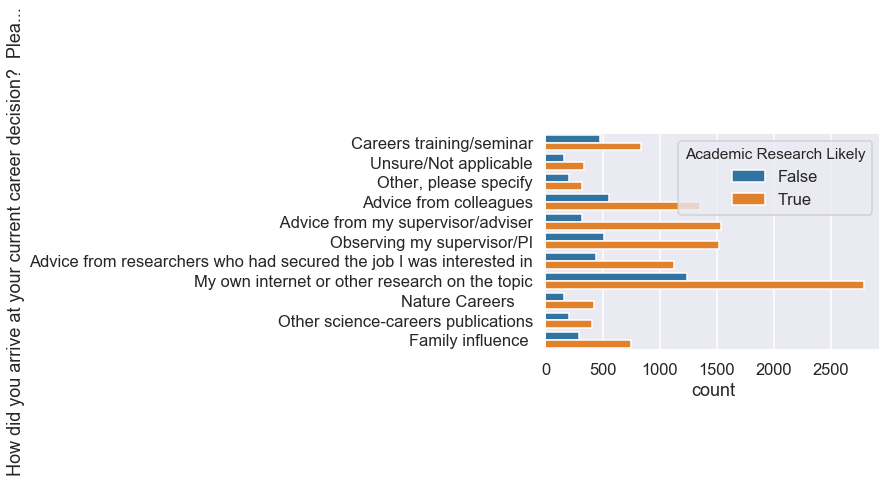

In [19]:
checkbox_plot('Q45')

# Model Building

In [20]:
import sklearn.preprocessing   as pre
import sklearn.pipeline        as pipe
import sklearn.impute          as imp
import sklearn.compose         as pipe2
import sklearn.dummy           as dum
import sklearn.metrics         as metr
import sklearn.linear_model    as lin
import sklearn.model_selection as cv

from joblib import dump, load

In [21]:
sns.set_style('dark')

## Setup

### Assemble the Data and Train/Test Split

In [22]:
codebook.var_type.value_counts()

Check Box      122
Ordinal         80
Categorical     17
Boolean          4
Name: var_type, dtype: int64

In [23]:
# Prevent Data Leakage
leakage_filter = filterQRange(36, 54)

categorical_vars = codebook[codebook.var_type.isin(['Boolean', 'Categorical'])].index.tolist()
categorical_vars = lfilter(leakage_filter, categorical_vars)
categorical_vars.remove('ID.site') # Quite irrelevant

ordinal_vars = codebook[codebook.var_type == 'Ordinal'].index.tolist()
ordinal_vars = lfilter(leakage_filter, ordinal_vars)

checkbox_vars = codebook[codebook.var_type == 'Check Box'].index.tolist()
checkbox_vars = lfilter(leakage_filter, checkbox_vars)

In [24]:
X_checkbox    = df.loc[:,checkbox_vars].astype(int)
X_ord         = df.loc[:,ordinal_vars]
X_cat         = df.loc[:,categorical_vars].astype(str)
X_cat         = pd.get_dummies(X_cat, drop_first=False)
X_all         = pd.concat([X_checkbox, X_ord, X_cat], axis = 'columns')

categorical_vars = X_cat.columns.tolist()

In [25]:
X_train, X_test, target_train, target_test = cv.train_test_split(X_all, target_all, random_state = 42)

#Aliases. Goal is to avoid accidentally training on test data.
X      = X_train
target = target_train
y      = target_train
y_test = target_test

### Imputation

For the ordinal variables we need to impute.

For the rankings, impute to bottom

For the 1-5 scales, impute to most common

In [26]:
# Identify the ranking variables
ordinal_book     = codebook.loc[ordinal_vars]
ranking_book     = ordinal_book[ordinal_book.notes.str.contains('[rR]anking').fillna(False)]
ranking_vars     = ranking_book.index.tolist()
non_ranking_vars = list_diff(ordinal_vars, ranking_vars)

In [27]:
# We can fill with bottom = 14
X[ranking_vars].max().value_counts()

14.0    14
dtype: int64

In [28]:
# Imputation plan for the ordinal variables
imputer = pipe2.ColumnTransformer([
    ('bottom', imp.SimpleImputer(strategy = 'constant', fill_value = 14), ranking_vars),
    ('freq'  , imp.SimpleImputer(strategy = 'most_frequent')            , non_ranking_vars)],
remainder = 'passthrough')

### Other Modelling Utilities

In [29]:
# Dict to record model data
models = {}

In [30]:
# Cross-Validation Splitter
splitter = cv.RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

# Modelling

## Baseline Model

In [31]:
model = dum.DummyClassifier(strategy = 'most_frequent')

In [32]:
model_data         = {'model' : model}
models['baseline'] = model_data

In [33]:
Timer.start()
model.fit(X, y)
Timer.end()
model_data['fit_time'] = Timer.time

0.0 seconds elapsed


In [34]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       498
        True       0.71      1.00      0.83      1205

    accuracy                           0.71      1703
   macro avg       0.35      0.50      0.41      1703
weighted avg       0.50      0.71      0.59      1703



/Users/rcharan/anaconda3/envs/learn37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


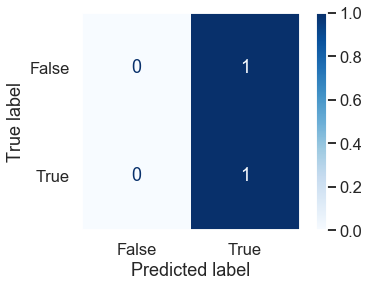

In [35]:
# Rows are normalized
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

## Logistic Regression – Unweighted

In [36]:
model_name = 'logistic'

In [37]:
learner = pipe.Pipeline([
    ('impute' , imputer),
    ('learn'  , lin.LogisticRegression(max_iter = 10000))
])

In [38]:
param_grid = {
     'penalty'    : ['elasticnet'],
     'l1_ratio'   : np.linspace( 0, 1, 6),
     'C'          : np.logspace(-3, 2, 6),
     'solver'     : ['saga']
}
param_grid = {'learn__' + k : list(v) for k, v in param_grid.items()}

In [39]:
model = cv.GridSearchCV(learner,
                        param_grid,
                        scoring = 'neg_log_loss',
                        cv = splitter,
                        n_jobs = n_jobs)

In [40]:
model_data         = {'model' : model}
models[model_name] = model_data

In [41]:
if not load_from_disk:
    Timer.start()
    model.fit(X, y)
    Timer.end()
    model_data['fit_time'] = Timer.time
    dump(model, './models/logistic.joblib')
else:
    model = load('./models/logistic.joblib')
    
    # Hard coded from when I ran it once
    model_data['fit_time'] = '1726.477'
    print('1726.477 seconds elapsed')

1726.477 seconds elapsed


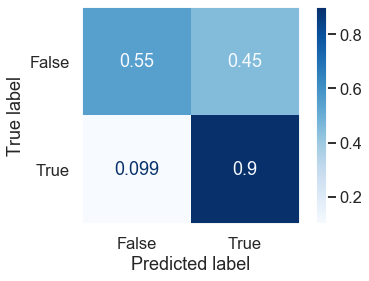

In [42]:
# Rows are normalized
plot(metr.plot_confusion_matrix, model, X_test, y_test, cmap=plt.cm.Blues, normalize = 'true')

In [43]:
y_hat = model.predict(X_test)
model_data['report'] = metr.classification_report(y_test, y_hat, zero_division = 0, output_dict=True)
print(metr.classification_report(y_test, y_hat, zero_division=0))

              precision    recall  f1-score   support

       False       0.70      0.55      0.61       498
        True       0.83      0.90      0.86      1205

    accuracy                           0.80      1703
   macro avg       0.76      0.72      0.74      1703
weighted avg       0.79      0.80      0.79      1703

